***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- Applying top-down approach. (Coarse-to-Fine)
- Changing the Secondary Capsule Dimension:
    - 8D>12D>16D (Coarse>Medium>FINE)
    - Just use Hinge Loss (MarginLoss) for each level.

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

DONE loading Datasets
DONE loading MixUp Data generator


# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\GitHub Repo\HDeep_CapsNet\code\training\CIFAR_100
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "3" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  3
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [12]:
directory = sysenv.log_dir('4_CIFAR_100/HD_CapsNet/Mod_1_4')

# Import Dataset : CIFAR-100

In [4]:
dataset = datasets.CIFAR100(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR100(version = 'reduce') # importing CIFAR10 Dataset


CIFAR-100 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [5]:
from src.models import *

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")
    return total_marginloss

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*margin_loss(y_true_m, y_pred_m)
    ML_f = LW_F*margin_loss(y_true_f, y_pred_f)
    batch_loss = ML_c + ML_m+ ML_f
    return tf.reduce_mean(batch_loss)

## Model Architecture

In [10]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = number_of_classes_c
    no_medium_class = number_of_classes_m
    no_fine_class = number_of_classes_f

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 12
    SCap_c_dims = 8


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    # input [batch_size, 6, 6, 512], output [batch_size, 2304, 8]
    reshapec = keras.layers.Reshape((256, PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_c)
    
    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(s_caps_m)

    pred_c = LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [11]:
model = get_compiled_model()

In [13]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.math.subtract_3 (TFOpLambda  (None, 20)          0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.subtract_4 (TFOpLambda  (None, 20)          0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.maximum (TFOpLambda)   (None, 8)            0           ['tf.math.subtract[0][0]']       
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 8)           0           ['input_yc[0][0]']               
 )        

 da)                                                                                              
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 100)          0           ['tf.math.multiply_8[0][0]',     
                                                                  'tf.math.multiply_10[0][0]']    
                                                                                                  
 tf.math.multiply_3 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum[0][0]']     
 )                                                                                                
                                                                                                  
 tf.math.multiply_7 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum_1[0][0]']   
 )                                                                                                
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/weights-{epoch:02d}.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
history = model.fit(training_generator,
                    steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                    epochs = train_params["n_epochs"],
                    validation_data = ([dataset['x_test'],
                                        dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                       [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                    callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                    
                    verbose=1)
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.save_weights(model_save_dir)
    print('Trained model saved to = ', model_save_dir)
except:
    print('Model Wight is not saved')

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.5076 - prediction_coarse_accuracy: 0.3827 - prediction_medium_accuracy: 0.2089 - prediction_fine_accuracy: 0.0901
  • Coarse Accuracy = 38.27% | Val_Accuracy = 56.87% | LossWeight = 0.40 
  • Medium Accuracy = 20.89% | Val_Accuracy = 33.26% | LossWeight = 0.46 
  • Fine   Accuracy = 9.01% | Val_Accuracy = 14.62% | LossWeight = 0.14 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.14620, saving model to ./logs/HD_CapsNet/WO_C_loss\weights-01.h5
781/781 [==============================] - 151s 184ms/step - loss: 0.5076 - prediction_coarse_accuracy: 0.3827 - prediction_medium_accuracy: 0.2089 - prediction_fine_accuracy: 0.0901 - val_loss: 0.3932 - val_prediction_coarse_accuracy: 0.5687 - val_prediction_medium_accuracy: 0.3326 - val_prediction_fine_accuracy: 0.1462 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.3634 - prediction_coarse_accuracy: 0.6117 - prediction_

781/781 [==============================] - 143s 183ms/step - loss: 0.1918 - prediction_coarse_accuracy: 0.8437 - prediction_medium_accuracy: 0.7497 - prediction_fine_accuracy: 0.5164 - val_loss: 0.1771 - val_prediction_coarse_accuracy: 0.8147 - val_prediction_medium_accuracy: 0.6984 - val_prediction_fine_accuracy: 0.5056 - lr: 0.0010
Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.1836 - prediction_coarse_accuracy: 0.8551 - prediction_medium_accuracy: 0.7690 - prediction_fine_accuracy: 0.5428
  • Coarse Accuracy = 85.51% | Val_Accuracy = 81.69% | LossWeight = 0.32 
  • Medium Accuracy = 76.90% | Val_Accuracy = 71.22% | LossWeight = 0.45 
  • Fine   Accuracy = 54.28% | Val_Accuracy = 52.30% | LossWeight = 0.23 

Epoch 10: val_prediction_fine_accuracy improved from 0.50560 to 0.52300, saving model to ./logs/HD_CapsNet/WO_C_loss\weights-10.h5
781/781 [==============================] - 143s 183ms/step - loss: 0.1836 - prediction_coarse_accuracy: 0.8551 - predictio

Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.1287 - prediction_coarse_accuracy: 0.9253 - prediction_medium_accuracy: 0.8858 - prediction_fine_accuracy: 0.6826
  • Coarse Accuracy = 92.53% | Val_Accuracy = 84.04% | LossWeight = 0.30 
  • Medium Accuracy = 88.58% | Val_Accuracy = 74.32% | LossWeight = 0.41 
  • Fine   Accuracy = 68.26% | Val_Accuracy = 58.70% | LossWeight = 0.29 

Epoch 19: val_prediction_fine_accuracy improved from 0.58180 to 0.58700, saving model to ./logs/HD_CapsNet/WO_C_loss\weights-19.h5
781/781 [==============================] - 143s 184ms/step - loss: 0.1287 - prediction_coarse_accuracy: 0.9253 - prediction_medium_accuracy: 0.8858 - prediction_fine_accuracy: 0.6826 - val_loss: 0.1551 - val_prediction_coarse_accuracy: 0.8404 - val_prediction_medium_accuracy: 0.7432 - val_prediction_fine_accuracy: 0.5870 - lr: 6.3025e-04
Epoch 20/100
781/781 [==============================] - ETA: 0s - loss: 0.1246 - prediction_coarse_accuracy: 0.9306 - 

781/781 [==============================] - 143s 183ms/step - loss: 0.1024 - prediction_coarse_accuracy: 0.9515 - prediction_medium_accuracy: 0.9362 - prediction_fine_accuracy: 0.7818 - val_loss: 0.1474 - val_prediction_coarse_accuracy: 0.8524 - val_prediction_medium_accuracy: 0.7642 - val_prediction_fine_accuracy: 0.6241 - lr: 2.5034e-04
Epoch 38/100
781/781 [==============================] - ETA: 0s - loss: 0.1030 - prediction_coarse_accuracy: 0.9509 - prediction_medium_accuracy: 0.9359 - prediction_fine_accuracy: 0.7808
  • Coarse Accuracy = 95.09% | Val_Accuracy = 85.47% | LossWeight = 0.31 
  • Medium Accuracy = 93.59% | Val_Accuracy = 77.12% | LossWeight = 0.37 
  • Fine   Accuracy = 78.08% | Val_Accuracy = 62.75% | LossWeight = 0.32 

Epoch 38: val_prediction_fine_accuracy improved from 0.62480 to 0.62750, saving model to ./logs/HD_CapsNet/WO_C_loss\weights-38.h5
781/781 [==============================] - 143s 184ms/step - loss: 0.1030 - prediction_coarse_accuracy: 0.9509 - predi

Epoch 47/100
781/781 [==============================] - ETA: 0s - loss: 0.0982 - prediction_coarse_accuracy: 0.9543 - prediction_medium_accuracy: 0.9407 - prediction_fine_accuracy: 0.8053
  • Coarse Accuracy = 95.43% | Val_Accuracy = 85.56% | LossWeight = 0.32 
  • Medium Accuracy = 94.07% | Val_Accuracy = 77.11% | LossWeight = 0.37 
  • Fine   Accuracy = 80.53% | Val_Accuracy = 63.51% | LossWeight = 0.31 

Epoch 47: val_prediction_fine_accuracy improved from 0.63490 to 0.63510, saving model to ./logs/HD_CapsNet/WO_C_loss\weights-47.h5
781/781 [==============================] - 145s 186ms/step - loss: 0.0982 - prediction_coarse_accuracy: 0.9543 - prediction_medium_accuracy: 0.9407 - prediction_fine_accuracy: 0.8053 - val_loss: 0.1446 - val_prediction_coarse_accuracy: 0.8556 - val_prediction_medium_accuracy: 0.7711 - val_prediction_fine_accuracy: 0.6351 - lr: 1.4989e-04
Epoch 48/100
781/781 [==============================] - ETA: 0s - loss: 0.0988 - prediction_coarse_accuracy: 0.9558 - 

781/781 [==============================] - 145s 186ms/step - loss: 0.0967 - prediction_coarse_accuracy: 0.9570 - prediction_medium_accuracy: 0.9438 - prediction_fine_accuracy: 0.8204 - val_loss: 0.1441 - val_prediction_coarse_accuracy: 0.8593 - val_prediction_medium_accuracy: 0.7727 - val_prediction_fine_accuracy: 0.6398 - lr: 9.4468e-05
Epoch 57/100
781/781 [==============================] - ETA: 0s - loss: 0.0954 - prediction_coarse_accuracy: 0.9579 - prediction_medium_accuracy: 0.9452 - prediction_fine_accuracy: 0.8222
  • Coarse Accuracy = 95.79% | Val_Accuracy = 85.98% | LossWeight = 0.32 
  • Medium Accuracy = 94.52% | Val_Accuracy = 77.33% | LossWeight = 0.37 
  • Fine   Accuracy = 82.22% | Val_Accuracy = 63.70% | LossWeight = 0.31 

Epoch 57: val_prediction_fine_accuracy did not improve from 0.63980
781/781 [==============================] - 145s 186ms/step - loss: 0.0954 - prediction_coarse_accuracy: 0.9579 - prediction_medium_accuracy: 0.9452 - prediction_fine_accuracy: 0.822

Epoch 66/100
781/781 [==============================] - ETA: 0s - loss: 0.0958 - prediction_coarse_accuracy: 0.9589 - prediction_medium_accuracy: 0.9464 - prediction_fine_accuracy: 0.8300
  • Coarse Accuracy = 95.89% | Val_Accuracy = 86.08% | LossWeight = 0.32 
  • Medium Accuracy = 94.64% | Val_Accuracy = 77.49% | LossWeight = 0.37 
  • Fine   Accuracy = 83.00% | Val_Accuracy = 64.21% | LossWeight = 0.31 

Epoch 66: val_prediction_fine_accuracy did not improve from 0.64350
781/781 [==============================] - 145s 186ms/step - loss: 0.0958 - prediction_coarse_accuracy: 0.9589 - prediction_medium_accuracy: 0.9464 - prediction_fine_accuracy: 0.8300 - val_loss: 0.1442 - val_prediction_coarse_accuracy: 0.8608 - val_prediction_medium_accuracy: 0.7749 - val_prediction_fine_accuracy: 0.6421 - lr: 5.6562e-05
Epoch 67/100
781/781 [==============================] - ETA: 0s - loss: 0.0949 - prediction_coarse_accuracy: 0.9579 - prediction_medium_accuracy: 0.9452 - prediction_fine_accuracy: 

781/781 [==============================] - 145s 186ms/step - loss: 0.0948 - prediction_coarse_accuracy: 0.9596 - prediction_medium_accuracy: 0.9475 - prediction_fine_accuracy: 0.8345 - val_loss: 0.1448 - val_prediction_coarse_accuracy: 0.8603 - val_prediction_medium_accuracy: 0.7776 - val_prediction_fine_accuracy: 0.6449 - lr: 3.5648e-05
Epoch 76/100
781/781 [==============================] - ETA: 0s - loss: 0.0940 - prediction_coarse_accuracy: 0.9597 - prediction_medium_accuracy: 0.9488 - prediction_fine_accuracy: 0.8368
  • Coarse Accuracy = 95.97% | Val_Accuracy = 86.19% | LossWeight = 0.32 
  • Medium Accuracy = 94.88% | Val_Accuracy = 77.84% | LossWeight = 0.37 
  • Fine   Accuracy = 83.68% | Val_Accuracy = 64.51% | LossWeight = 0.31 

Epoch 76: val_prediction_fine_accuracy improved from 0.64490 to 0.64510, saving model to ./logs/HD_CapsNet/WO_C_loss\weights-76.h5
781/781 [==============================] - 145s 186ms/step - loss: 0.0940 - prediction_coarse_accuracy: 0.9597 - predi

Epoch 85/100
781/781 [==============================] - ETA: 0s - loss: 0.0946 - prediction_coarse_accuracy: 0.9581 - prediction_medium_accuracy: 0.9470 - prediction_fine_accuracy: 0.8387
  • Coarse Accuracy = 95.81% | Val_Accuracy = 86.10% | LossWeight = 0.33 
  • Medium Accuracy = 94.70% | Val_Accuracy = 77.71% | LossWeight = 0.37 
  • Fine   Accuracy = 83.87% | Val_Accuracy = 64.69% | LossWeight = 0.30 

Epoch 85: val_prediction_fine_accuracy did not improve from 0.64760
781/781 [==============================] - 145s 185ms/step - loss: 0.0946 - prediction_coarse_accuracy: 0.9581 - prediction_medium_accuracy: 0.9470 - prediction_fine_accuracy: 0.8387 - val_loss: 0.1439 - val_prediction_coarse_accuracy: 0.8610 - val_prediction_medium_accuracy: 0.7771 - val_prediction_fine_accuracy: 0.6469 - lr: 2.1344e-05
Epoch 86/100
781/781 [==============================] - ETA: 0s - loss: 0.0948 - prediction_coarse_accuracy: 0.9590 - prediction_medium_accuracy: 0.9477 - prediction_fine_accuracy: 

781/781 [==============================] - 145s 185ms/step - loss: 0.0943 - prediction_coarse_accuracy: 0.9601 - prediction_medium_accuracy: 0.9482 - prediction_fine_accuracy: 0.8420 - val_loss: 0.1435 - val_prediction_coarse_accuracy: 0.8601 - val_prediction_medium_accuracy: 0.7787 - val_prediction_fine_accuracy: 0.6478 - lr: 1.3452e-05
Epoch 95/100
781/781 [==============================] - ETA: 0s - loss: 0.0933 - prediction_coarse_accuracy: 0.9592 - prediction_medium_accuracy: 0.9490 - prediction_fine_accuracy: 0.8419
  • Coarse Accuracy = 95.92% | Val_Accuracy = 86.04% | LossWeight = 0.33 
  • Medium Accuracy = 94.90% | Val_Accuracy = 77.97% | LossWeight = 0.37 
  • Fine   Accuracy = 84.19% | Val_Accuracy = 64.81% | LossWeight = 0.30 

Epoch 95: val_prediction_fine_accuracy did not improve from 0.64810
781/781 [==============================] - 145s 185ms/step - loss: 0.0933 - prediction_coarse_accuracy: 0.9592 - prediction_medium_accuracy: 0.9490 - prediction_fine_accuracy: 0.841

In [17]:
history_dict = history.history

(0.0, 1.0)

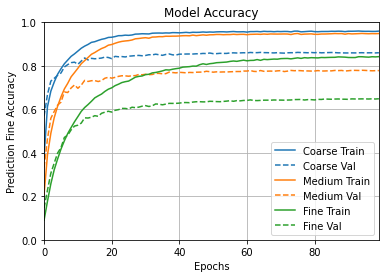

In [18]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

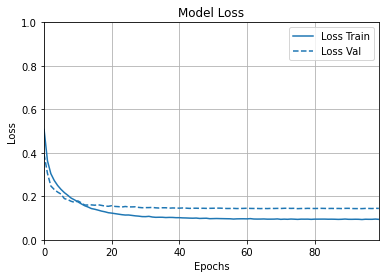

In [19]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"loss": history}, metric = "loss")
plt.title("Model Loss")
plt.ylim([0,1])

## Model Analysis

In [20]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : MarginLoss(),
                          'prediction_medium' : MarginLoss(),
                          'prediction_coarse' : MarginLoss()},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 13s 38ms/step - loss: 0.1871 - prediction_coarse_loss: 0.1187 - prediction_medium_loss: 0.1781 - prediction_fine_loss: 0.2730 - prediction_coarse_accuracy: 0.8603 - prediction_medium_accuracy: 0.7783 - prediction_fine_accuracy: 0.6487
1. loss ==> 0.18705631792545319
2. prediction_coarse_loss ==> 0.11865628510713577
3. prediction_medium_loss ==> 0.17814666032791138
4. prediction_fine_loss ==> 0.2730361223220825
5. prediction_coarse_accuracy ==> 0.8603000044822693
6. prediction_medium_accuracy ==> 0.7782999873161316
7. prediction_fine_accuracy ==> 0.6486999988555908
313/313 [==============================] - 10s 30ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

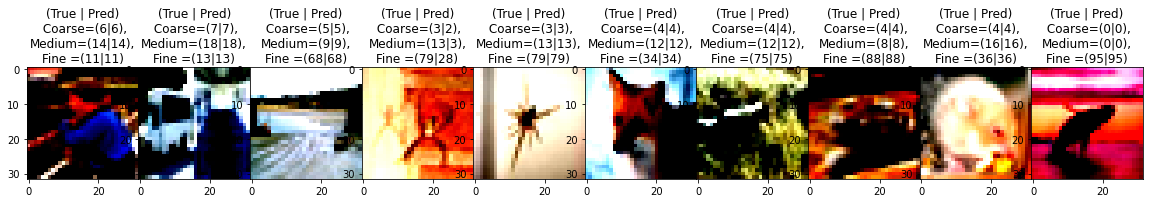

In [21]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 711   10   21   30  190   12   12   14]
 [   5 1378   26   26   35   26    1    3]
 [  11   25 1359   25   32    5   15   28]
 [  19   34   30  795  108    0    4   10]
 [ 107   26   48   82 2175   10   27   25]
 [   9   28   24    5   28  875    1   30]
 [   5   12   12   11   40    2  416    2]
 [   5    5   32   10   30   24    0  894]]

  • MEDIUM LEVEL 
[[320  24   0   2   1   6   1   2  23   5   2  16  16  15   9  26  23   0
    5   4]
 [ 26 368   5   6   5   6   2  10   4   8   2   3   8   9   9  18   5   0
    3   3]
 [  0   3 442   4  19   5   0  15   1   1   3   0   1   2   2   2   0   0
    0   0]
 [  1   1   3 405  11  37  11   3   2   1   1   1   2   6   6   1   0   0
    2   6]
 [  2   1  19   4 429   5   1   6   6   2   3   4   1   6   0   7   2   2
    0   0]
 [  2   3   2  32   8 378  19   3   1   4   0   1   1  10   7   5   5   2
    5  12]
 [  2   4   1   8   3  25 428   0   0   2   1   0   1   4   8   3   0   1
    6   3]


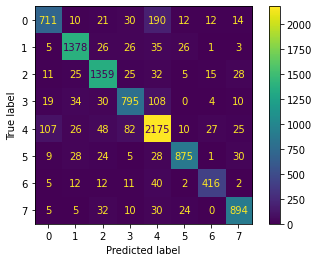

              precision    recall  f1-score   support

           0    0.81537   0.71100   0.75962      1000
           1    0.90777   0.91867   0.91319      1500
           2    0.87564   0.90600   0.89056      1500
           3    0.80793   0.79500   0.80141      1000
           4    0.82449   0.87000   0.84663      2500
           5    0.91719   0.87500   0.89560      1000
           6    0.87395   0.83200   0.85246       500
           7    0.88867   0.89400   0.89133      1000

    accuracy                        0.86030     10000
   macro avg    0.86388   0.85021   0.85635     10000
weighted avg    0.86025   0.86030   0.85964     10000


  • MEDIUM LEVEL 


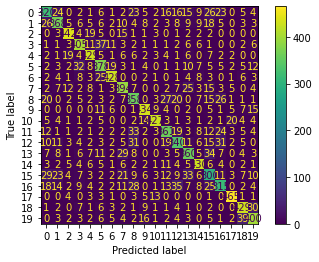

              precision    recall  f1-score   support

           0    0.69565   0.64000   0.66667       500
           1    0.76827   0.73600   0.75179       500
           2    0.86837   0.88400   0.87611       500
           3    0.79256   0.81000   0.80119       500
           4    0.82979   0.85800   0.84366       500
           5    0.72414   0.75600   0.73973       500
           6    0.86815   0.85600   0.86203       500
           7    0.75769   0.78800   0.77255       500
           8    0.68582   0.71600   0.70059       500
           9    0.84932   0.86800   0.85856       500
          10    0.90084   0.85400   0.87680       500
          11    0.74741   0.72200   0.73449       500
          12    0.71130   0.68000   0.69530       500
          13    0.71287   0.72000   0.71642       500
          14    0.83495   0.86000   0.84729       500
          15    0.60120   0.60000   0.60060       500
          16    0.68627   0.63000   0.65693       500
          17    0.90998   0

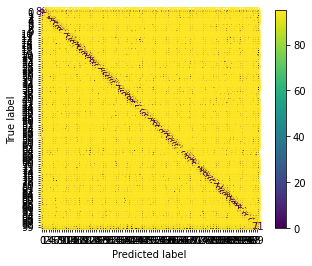

              precision    recall  f1-score   support

           0    0.81633   0.80000   0.80808       100
           1    0.72174   0.83000   0.77209       100
           2    0.55102   0.54000   0.54545       100
           3    0.45055   0.41000   0.42932       100
           4    0.52174   0.48000   0.50000       100
           5    0.68868   0.73000   0.70874       100
           6    0.68182   0.75000   0.71429       100
           7    0.62626   0.62000   0.62312       100
           8    0.83838   0.83000   0.83417       100
           9    0.81818   0.81000   0.81407       100
          10    0.54945   0.50000   0.52356       100
          11    0.44330   0.43000   0.43655       100
          12    0.71296   0.77000   0.74038       100
          13    0.65217   0.60000   0.62500       100
          14    0.51695   0.61000   0.55963       100
          15    0.60684   0.71000   0.65438       100
          16    0.69388   0.68000   0.68687       100
          17    0.85714   0

In [22]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [23]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7604266666666667 
Hierarchical Recall = 0.7787333333333334 
Hierarchical F1-Score = 0.7675444444444445 
Consistency =  0.8981 
Exact Match =  0.6253
